In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl
from statsmodels.tsa.seasonal import STL

# Подгружаем данные

In [2]:
data = pd.read_csv(r'C:\Users\Lenovo\Documents\monthly-beer-production-in-austr.csv',index_col='Month')
data['t'] = np.arange(len(data))+1

Проблема первостепенности данных: что появилось раньше: курица или яйцо?

In [3]:
data.columns = ['y','t']
data.dtypes

y    float64
t      int32
dtype: object

In [4]:
data = data[['t','y']]

In [5]:
# regex = re.compile(r'[-+]?(?:\d*\.*\d+)')
# data = data['y'].apply(lambda x:re.findall(regex,x)[0]).astype(float)

data.index = pd.to_datetime(data.index)


<AxesSubplot: xlabel='Month', ylabel='y'>

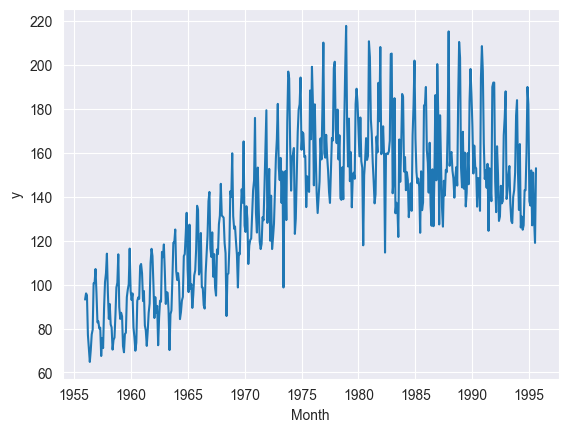

In [6]:
sns.lineplot(x=data.index,y=data.y)

In [7]:
stl = STL(data.y,period=12).fit()

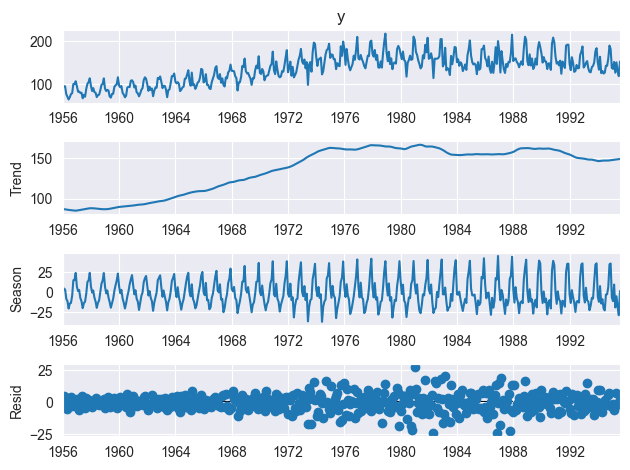

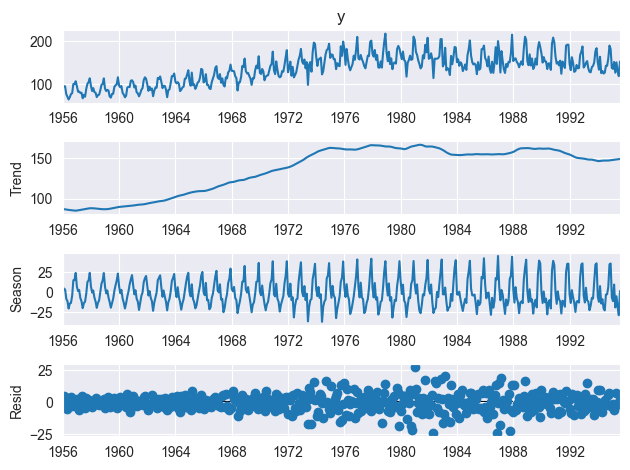

In [8]:
stl.plot()

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


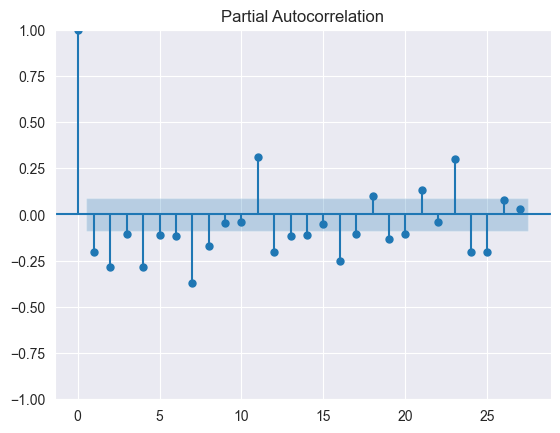

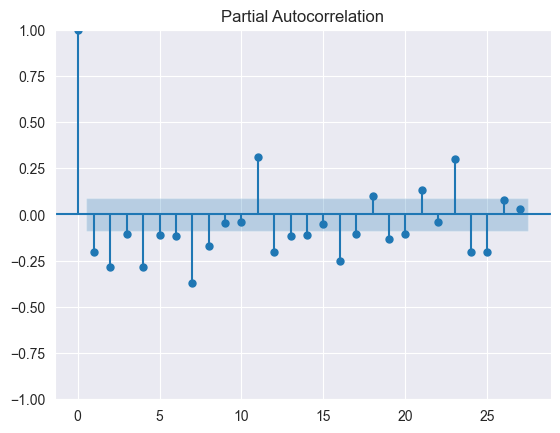

In [9]:
plot_pacf(stl.resid)

class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] +
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] -
                                      self.scaling_factor *
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01)

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i])
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] +
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] -
                                  self.scaling_factor *
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

model = HoltWinters(data.x,)

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [11]:
data_train = data[:-36]
data_test = data[-36:]

C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


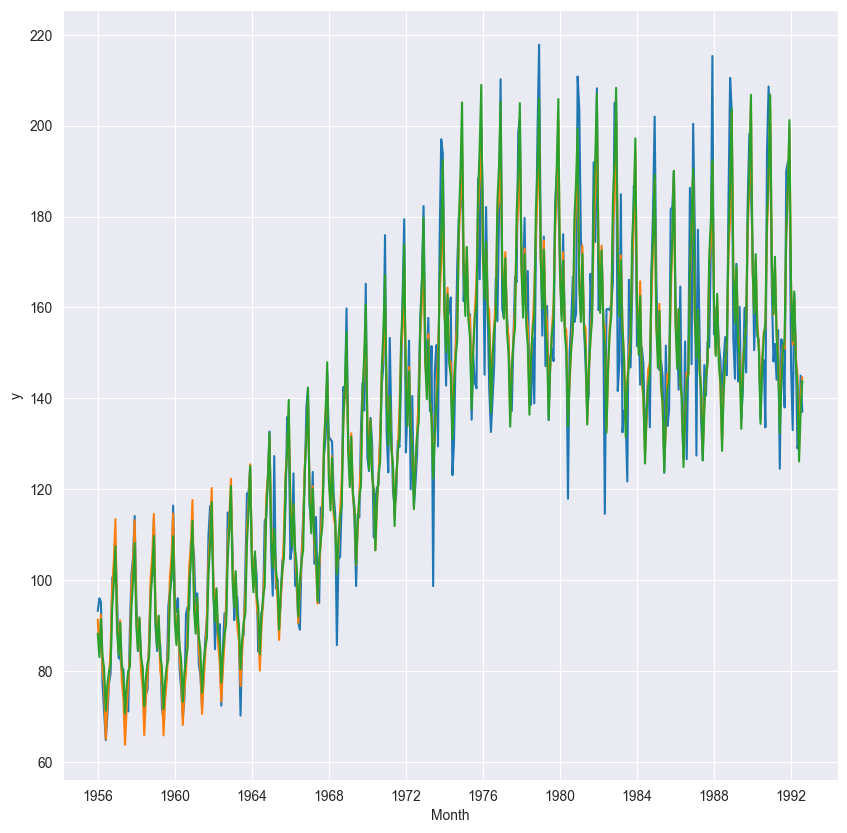

In [13]:
fit1 = ExponentialSmoothing(
    data_train.y,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
fit2 = ExponentialSmoothing(
    data_train.y,
    seasonal_periods=12,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()


params = [
    "smoothing_level",
    "smoothing_trend",
    "damping_trend",
    "smoothing_seasonal",
    "initial_level",
    "initial_trend",
]


plt.figure(figsize=(10,10))
sns.lineplot(x=data_train.index,y=data_train.y)
sns.lineplot(x=data_train.index,y=fit1.fittedvalues) #"Holt-Winters (add-add-seasonal)"
sns.lineplot(x=data_train.index,y=fit2.fittedvalues)

plt.show()


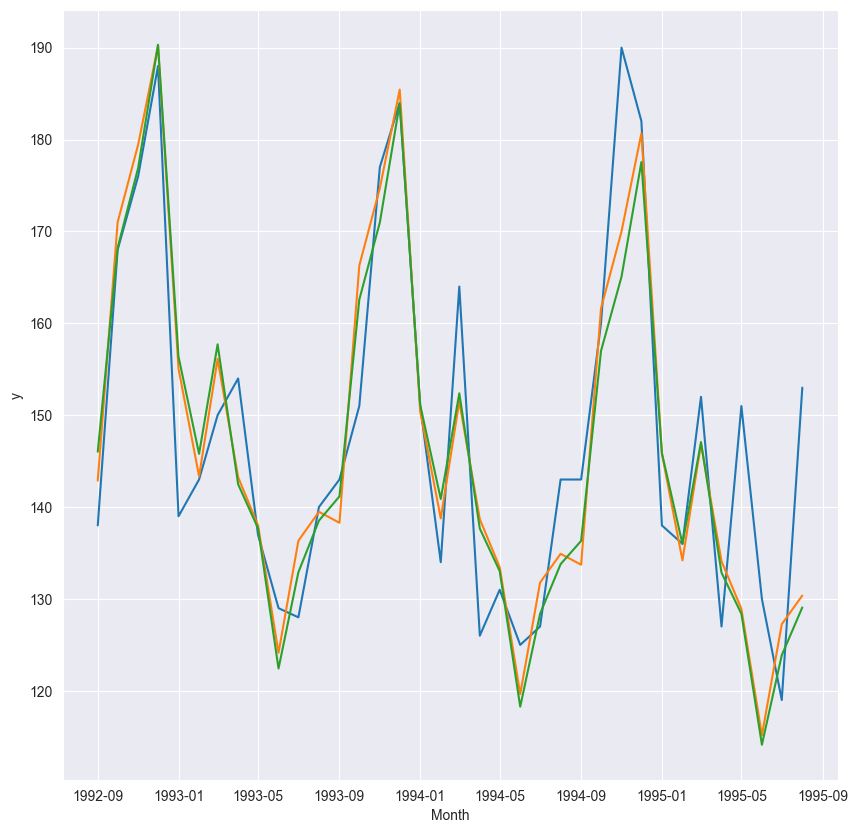

In [14]:
plt.figure(figsize=(10,10))
sns.lineplot(x=data_test.index,y=data_test.y)
sns.lineplot(x=data_test.index,y=fit1.forecast(36)) #"Holt-Winters (add-add-seasonal)"
sns.lineplot(x=data_test.index,y=fit2.forecast(36)) #"Holt-Winters (add-mul-seasonal)"

plt.show()


![](sber.jpg)

# LSTM

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(data.values.reshape(-1,1))

train_scaled = torch.FloatTensor(train_scaled)
train_scaled = train_scaled.view(-1)


In [16]:
def get_x_y_pairs(train_scaled, train_periods, prediction_periods):
    """
    train_scaled - training sequence
    train_periods - How many data points to use as inputs
    prediction_periods - How many periods to ouput as predictions
    """
    x_train = [train_scaled[i:i+train_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]
    y_train = [train_scaled[i+train_periods:i+train_periods+prediction_periods] for i in range(len(train_scaled)-train_periods-prediction_periods)]

    #-- use the stack function to convert the list of 1D tensors
    # into a 2D tensor where each element of the list is now a row
    x_train = torch.stack(x_train)
    y_train = torch.stack(y_train)

    return x_train, y_train

train_periods = 440 #-- number of quarters for input
prediction_periods = 36
x_train, y_train = get_x_y_pairs(train_scaled, train_periods, prediction_periods)
print(x_train.shape)
print(y_train.shape)
torch.Size([11, 16])
torch.Size([11, 8])

torch.Size([476, 440])
torch.Size([476, 36])


torch.Size([11, 8])

In [17]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        if hidden==None:
            self.hidden = (torch.zeros(1,1,self.hidden_size),
                           torch.zeros(1,1,self.hidden_size))
        else:
            self.hidden = hidden

        lstm_out, self.hidden = self.lstm(x.view(len(x),1,-1),
                                          self.hidden)

        predictions = self.linear(lstm_out.view(len(x), -1))

        return predictions[-1], self.hidden

In [18]:
model = LSTM(input_size=1, hidden_size=50, output_size=36)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100
model.train()
for epoch in range(epochs+1):
    for x,y in zip(x_train, y_train):
        y_hat, _ = model(x, None)
        optimizer.zero_grad()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

    if epoch%10==0:
        print(f'epoch: {epoch:4} loss:{loss.item():10.8f}')

model.eval()


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    predictions, _ = model(data_test.y, None)
predictions

In [ ]:
data_test.y

In [ ]:
x = data.index
font = {'size'   : 15}

mpl.rc('font', **font)
fig = plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(x[:-len(predictions)],
         data.x[:-len(predictions)],
         "b-")
plt.plot(x[-len(predictions):],
         data.x[-len(predictions):],
         "b--",
         label='True Values')
plt.plot(x[-len(predictions):],
         predictions,
         "r-",
         label='Predicted Values')
plt.legend()
plt.savefig('plot1', dpi=600)


* бизнес суть процеессов
* ложная корреляуция
* почему важно кнлм
* математика - плохо, сбер - хорощо
*